# 1 Required Packages

In [1]:
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import csv
import torchvision.models as models
import torchvision

import time

from sklearn.metrics import confusion_matrix, roc_curve, auc

from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

# from torchcam.methods import SmoothGradCAMpp, LayerCAM
# from torchcam.utils import overlay_mask

import random

In [2]:
# always check your version
print(torch.__version__)
# check if gpu/cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

1.13.1
Using device: cuda


# 2 Overview (Need to modify)

1. Function implementation

2. Model Training

3. Model Fine-tuning

4. Model Testing

5. Model Comparison

6. Interpretation of results



# 3 Function implementation

## 3.1 Dataset Class

In [3]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

## 3.2 Top-K Accuracy

In [4]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

## 3.3 Progress Training Plotting

In [5]:
# plot training progress
def plot_training_progress(results_path):
    data = torch.load(results_path)
    fig, ax1 = plt.subplots()
    plt.plot(data["train_loss"], 'r', label = 'train_loss')
    plt.plot(data["val_loss"], 'm', label = 'val_loss')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    ax2=ax1.twinx()
    plt.plot(data["train_accuracy"], 'g', label = 'train_accuracy')
    plt.plot(data["val_accuracy"], 'b', label = 'val_accuracy')
    plt.legend(loc='lower right')
    ax2.set_ylabel('accuracy')

    plt.show()

# 4 Model

## 4.1 Simple CNN Model

Create a simple model class using a combination of:
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

In [6]:
# TO COMPLETE
# define a CNN Model class
class SimpleCNN(nn.Sequential): # Same as nn.Model
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8, kernel_size=2, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.pooling1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16, kernel_size=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.pooling3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64, kernel_size=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.pooling4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=64,out_channels=128, kernel_size=2, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.ReLU()
        self.pooling5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv6 = nn.Conv2d(in_channels=128,out_channels=256, kernel_size=2, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.pooling6 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.1)
        self.relu7 = nn.ReLU()
        self.fc1 = nn.Linear(4096, 64)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(64, 4)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pooling1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pooling2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pooling3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pooling4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pooling5(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pooling6(x)

        x = self.flatten(x)
        # x = self.dropout1(x)
        x = self.fc1(x)
        # x = self.dropout2(x)
        x = self.relu7(x)
        x = self.fc2(x)

        return x


## 4.2 Dataset Reading

In [7]:
# dataset path
ROOT = "./mushroom_dataset_4_classes/"
root_dir = ROOT
# direct read classes
classes = os.listdir(root_dir)
img_paths = []
labels = []

for class_idx, class_name in enumerate(sorted(classes)):
    class_dir = os.path.join(root_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img_paths.append(img_path)
        labels.append(class_idx)

print(len(img_paths))
print(len(labels))

8781
8781


### 4.2.1 Take a  look at the label-class mapping

In [8]:
for index in range(4):
    class_name = classes[index]
    print(index, class_name)

0 conditionally_edible
1 deadly
2 edible
3 poisonous


### 4.2.2 Split dataset to train:val = 8:2

In [9]:
# train val split(ratio = 8:2)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    img_paths, labels, test_size=0.2, stratify=labels, random_state=42) # 42 is answer to all...
print(train_paths.__len__())
print(val_paths.__len__())
print(train_labels.__len__())
print(val_labels.__len__())

7024
1757
7024
1757


### 4.2.3 Define transform abd Build Dataset (no aug & aug)

In [10]:
# No augmentation on training dataset
noaug_train_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

# No augmentation on validation dataset
val_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

# With augmentation on training dataset
aug_train_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),  # Horizontal Flipping
    transforms.RandomRotation(10),  # RandomRotation (-10 ~ +10)
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor()
])

train_dataset_noaug = CustomDataset(
    train_paths,
    train_labels,
    transform=noaug_train_transform
)

train_dataset_aug = CustomDataset(
    train_paths,
    train_labels,
    transform=aug_train_transform
)

val_dataset = CustomDataset(
    val_paths,
    val_labels,
    transform=val_transform
)

train_loader_noaug = DataLoader(
    train_dataset_noaug,
    batch_size=128,
    shuffle=True
)

train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=128,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False
)

### 4.2.4 Display some sample images

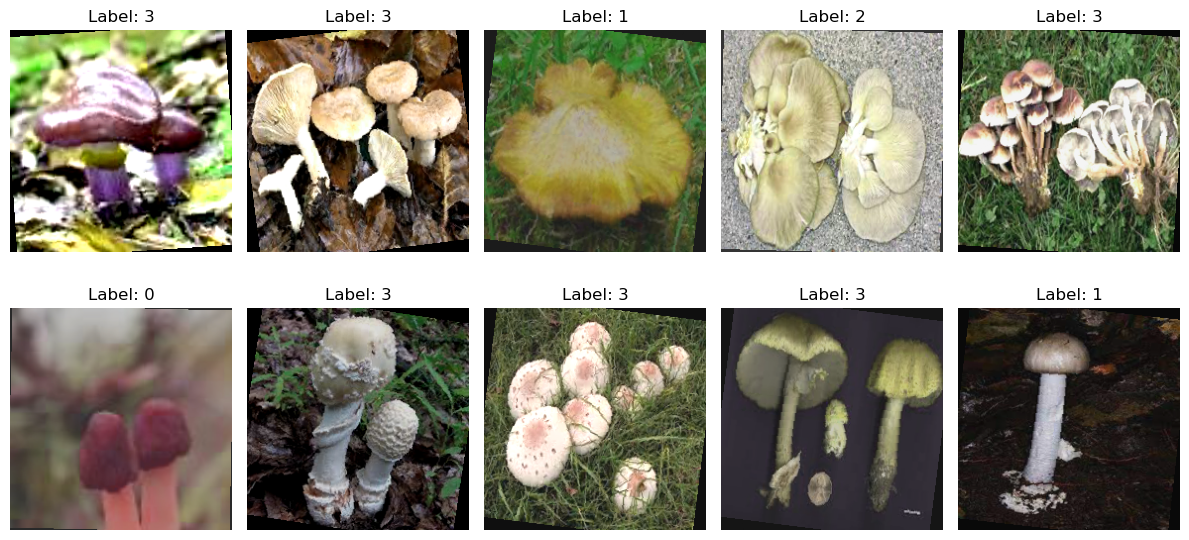

In [11]:
# display some samples
# get one batch
data, labels = next(iter(train_loader_aug))
# data, labels = next(iter(val_loader))

# choose first 10 images
images = data[:10]
labels = labels[:10]

# better for display for no aug
images = images.permute(0, 2, 3, 1)

# draw
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images[i])
    axs[i].set_title('Label: {}'.format(labels[i]))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# 5 Training Simple CNN Model

## 5.1 No Augmentation

In [12]:
# time recording start
start_time = time.time()

#TO COMPLETE --> Running you CNN model class
ResultPath = "./results/"
results_path = ResultPath + 'simplecnn-epochs50-adam-lr0.001-noaug-bs128128-3080-top1.pt'
nepochs = 50
SimpleCNN_for_noaug = SimpleCNN()
SimpleCNN_for_noaug.to(device)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(nepochs)
train_accuracy = np.zeros(nepochs)
val_loss = np.zeros(nepochs)
val_accuracy = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SimpleCNN_for_noaug.parameters(), lr=0.001)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # train
    SimpleCNN_for_noaug.train()
    for data in train_loader_noaug:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = SimpleCNN_for_noaug(inputs)

        # calculate top-k accuracy
        correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

        # accumulate accuracy for this batch
        num_correct_k = correct_k.item() / 100 * labels.size(0)
        correct += num_correct_k

        total += labels.size(0)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1    

    # record the mean loss for this epoch and show progress
    train_loss[epoch] = running_loss / n
    train_accuracy[epoch] = correct / total
    
    # reset variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # val
    SimpleCNN_for_noaug.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward and accumulate loss
            outputs = SimpleCNN_for_noaug(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            n += 1

            # calculate top-k accuracy
            correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

            num_correct_k = correct_k.item() / 100 * labels.size(0)
            correct += num_correct_k
            
            total += labels.size(0)

    # calculate test accuracy and loss
    val_loss[epoch] = running_loss / n
    val_accuracy[epoch] = correct / total

    print(f"epoch: {epoch+1} training loss: {train_loss[epoch]: .3f} training accuracy: {train_accuracy[epoch]: .1%}  val loss: {val_loss[epoch]: .3f} val accuracy: {val_accuracy[epoch]: .1%}")

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

# save network parameters and four features
data = {
    'state_dict': SimpleCNN_for_noaug.state_dict(),
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
    'total_time': total_time
}
torch.save(data, results_path)

epoch: 1 training loss:  1.215 training accuracy:  50.5%  val loss:  1.078 val accuracy:  54.5%
epoch: 2 training loss:  1.074 training accuracy:  54.2%  val loss:  1.072 val accuracy:  54.7%
epoch: 3 training loss:  1.053 training accuracy:  55.2%  val loss:  1.067 val accuracy:  55.2%
epoch: 4 training loss:  1.040 training accuracy:  55.7%  val loss:  1.073 val accuracy:  55.3%
epoch: 5 training loss:  1.002 training accuracy:  57.8%  val loss:  1.054 val accuracy:  56.5%
epoch: 6 training loss:  0.977 training accuracy:  59.7%  val loss:  1.036 val accuracy:  56.3%
epoch: 7 training loss:  0.943 training accuracy:  61.2%  val loss:  1.173 val accuracy:  56.2%
epoch: 8 training loss:  0.890 training accuracy:  62.9%  val loss:  1.108 val accuracy:  52.5%
epoch: 9 training loss:  0.832 training accuracy:  65.9%  val loss:  1.174 val accuracy:  54.4%
epoch: 10 training loss:  0.751 training accuracy:  69.7%  val loss:  1.159 val accuracy:  55.5%
epoch: 11 training loss:  0.651 trainin

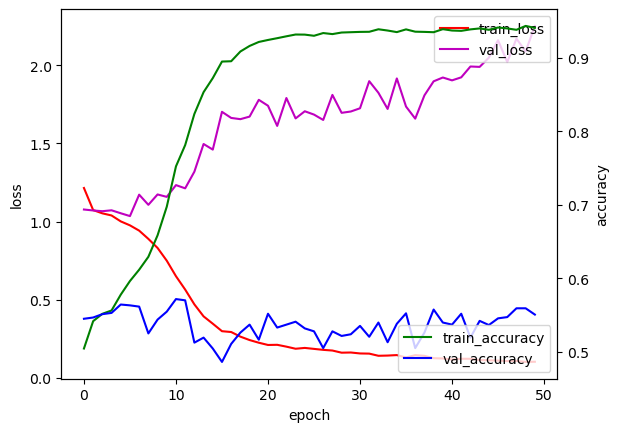

In [13]:
plot_training_progress(results_path)

## 5.2 Augmentation

In [14]:
# time recording start
start_time = time.time()

#TO COMPLETE --> Running you CNN model class
ResultPath = "./results/"
results_path = ResultPath + 'simplecnn-epochs50-adam-lr0.001-aug-bs128128-3080-top1.pt'
nepochs = 50
SimpleCNN_for_aug = SimpleCNN()
SimpleCNN_for_aug.to(device)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(nepochs)
train_accuracy = np.zeros(nepochs)
val_loss = np.zeros(nepochs)
val_accuracy = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SimpleCNN_for_aug.parameters(), lr=0.001)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # train
    SimpleCNN_for_aug.train()
    for data in train_loader_aug:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = SimpleCNN_for_aug(inputs)

        # calculate top-k accuracy
        correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

        # accumulate accuracy for this batch
        num_correct_k = correct_k.item() / 100 * labels.size(0)
        correct += num_correct_k

        total += labels.size(0)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1    

    # record the mean loss for this epoch and show progress
    train_loss[epoch] = running_loss / n
    train_accuracy[epoch] = correct / total
    
    # reset variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # val
    SimpleCNN_for_aug.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward and accumulate loss
            outputs = SimpleCNN_for_aug(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            n += 1

            # calculate top-k accuracy
            correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

            num_correct_k = correct_k.item() / 100 * labels.size(0)
            correct += num_correct_k
            
            total += labels.size(0)

    # calculate test accuracy and loss
    val_loss[epoch] = running_loss / n
    val_accuracy[epoch] = correct / total

    print(f"epoch: {epoch+1} training loss: {train_loss[epoch]: .3f} training accuracy: {train_accuracy[epoch]: .1%}  val loss: {val_loss[epoch]: .3f} val accuracy: {val_accuracy[epoch]: .1%}")

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

# save network parameters and four features
data = {
    'state_dict': SimpleCNN_for_aug.state_dict(),
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
    'total_time': total_time
}
torch.save(data, results_path)

epoch: 1 training loss:  1.171 training accuracy:  51.9%  val loss:  1.086 val accuracy:  53.8%
epoch: 2 training loss:  1.109 training accuracy:  53.0%  val loss:  1.083 val accuracy:  53.7%
epoch: 3 training loss:  1.087 training accuracy:  53.3%  val loss:  1.066 val accuracy:  54.1%
epoch: 4 training loss:  1.080 training accuracy:  54.6%  val loss:  1.073 val accuracy:  53.0%
epoch: 5 training loss:  1.069 training accuracy:  54.7%  val loss:  1.069 val accuracy:  54.8%
epoch: 6 training loss:  1.063 training accuracy:  54.8%  val loss:  1.088 val accuracy:  54.8%
epoch: 7 training loss:  1.057 training accuracy:  55.4%  val loss:  1.071 val accuracy:  55.2%
epoch: 8 training loss:  1.044 training accuracy:  56.0%  val loss:  1.086 val accuracy:  53.9%
epoch: 9 training loss:  1.032 training accuracy:  56.9%  val loss:  1.047 val accuracy:  55.4%
epoch: 10 training loss:  1.030 training accuracy:  56.1%  val loss:  1.052 val accuracy:  55.5%
epoch: 11 training loss:  1.028 trainin

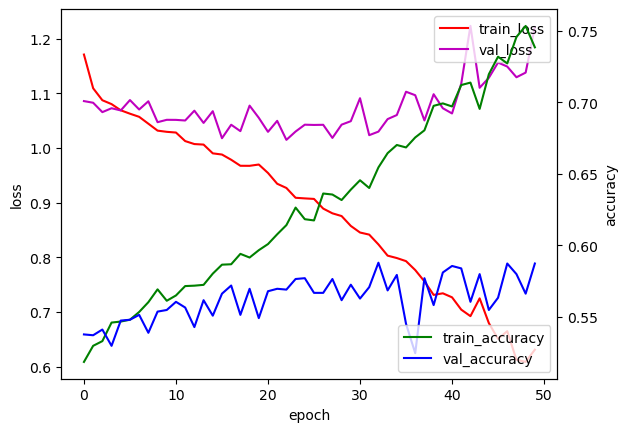

In [15]:
plot_training_progress(results_path)

# 6 Training ResNext Model (Only Last FCL)

## 6.1 No Augmentation

In [16]:
ResNeXt_noaug = models.resnext101_64x4d(pretrained=True)

for param in ResNeXt_noaug.parameters():
    param.requires_grad = False

num_classes = 4
ResNeXt_noaug.fc = nn.Linear(ResNeXt_noaug.fc.in_features, num_classes)

# time recording start
start_time = time.time()

#TO COMPLETE --> Running you CNN model class
ResultPath = "./results/"
results_path = ResultPath + 'resnext-epochs50-adam-lr0.001-noaug-bs128128-3080-top1.pt'
nepochs = 50
ResNeXt_noaug.to(device)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(nepochs)
train_accuracy = np.zeros(nepochs)
val_loss = np.zeros(nepochs)
val_accuracy = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
loss_fn = nn.CrossEntropyLoss()
# Only last fc layer?
optimizer = torch.optim.Adam(ResNeXt_noaug.fc.parameters(), lr=0.001)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # train
    ResNeXt_noaug.train()
    for data in train_loader_noaug:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = ResNeXt_noaug(inputs)

        # calculate top-k accuracy
        correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

        # accumulate accuracy for this batch
        num_correct_k = correct_k.item() / 100 * labels.size(0)
        correct += num_correct_k

        total += labels.size(0)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1    

    # record the mean loss for this epoch and show progress
    train_loss[epoch] = running_loss / n
    train_accuracy[epoch] = correct / total
    
    # reset variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # val
    ResNeXt_noaug.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward and accumulate loss
            outputs = ResNeXt_noaug(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            n += 1

            # calculate top-k accuracy
            correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

            num_correct_k = correct_k.item() / 100 * labels.size(0)
            correct += num_correct_k
            
            total += labels.size(0)

    # calculate test accuracy and loss
    val_loss[epoch] = running_loss / n
    val_accuracy[epoch] = correct / total

    print(f"epoch: {epoch+1} training loss: {train_loss[epoch]: .3f} training accuracy: {train_accuracy[epoch]: .1%}  val loss: {val_loss[epoch]: .3f} val accuracy: {val_accuracy[epoch]: .1%}")

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

# save network parameters and four features
data = {
    'state_dict': ResNeXt_noaug.state_dict(),
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
    'total_time': total_time
}
torch.save(data, results_path)

c:\ProgramData\Anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 1 training loss:  1.096 training accuracy:  54.7%  val loss:  1.052 val accuracy:  58.4%
epoch: 2 training loss:  0.997 training accuracy:  59.3%  val loss:  1.010 val accuracy:  58.9%
epoch: 3 training loss:  0.947 training accuracy:  60.9%  val loss:  0.990 val accuracy:  59.5%
epoch: 4 training loss:  0.911 training accuracy:  62.6%  val loss:  0.976 val accuracy:  60.2%
epoch: 5 training loss:  0.885 training accuracy:  63.2%  val loss:  0.965 val accuracy:  60.4%
epoch: 6 training loss:  0.859 training accuracy:  65.1%  val loss:  0.957 val accuracy:  60.6%
epoch: 7 training loss:  0.841 training accuracy:  65.8%  val loss:  0.953 val accuracy:  61.0%
epoch: 8 training loss:  0.823 training accuracy:  66.3%  val loss:  0.949 val accuracy:  60.8%
epoch: 9 training loss:  0.808 training accuracy:  67.1%  val loss:  0.949 val accuracy:  61.4%
epoch: 10 training loss:  0.796 training accuracy:  67.4%  val loss:  0.946 val accuracy:  61.4%
epoch: 11 training loss:  0.784 trainin

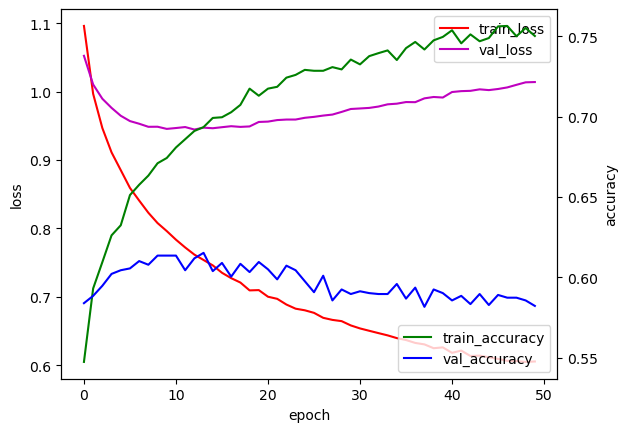

In [17]:
plot_training_progress(results_path)

## 6.2 Augmentation

In [18]:
ResNeXt_aug = models.resnext101_64x4d(pretrained=True)

for param in ResNeXt_aug.parameters():
    param.requires_grad = False

num_classes = 4
ResNeXt_aug.fc = nn.Linear(ResNeXt_aug.fc.in_features, num_classes)

# time recording start
start_time = time.time()

#TO COMPLETE --> Running you CNN model class
ResultPath = "./results/"
results_path = ResultPath + 'resnext-epochs50-adam-lr0.001-aug-bs128128-3080-top1.pt'
nepochs = 50
ResNeXt_aug.to(device)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(nepochs)
train_accuracy = np.zeros(nepochs)
val_loss = np.zeros(nepochs)
val_accuracy = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
loss_fn = nn.CrossEntropyLoss()
# Only last fc layer?
optimizer = torch.optim.Adam(ResNeXt_aug.fc.parameters(), lr=0.001)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # train
    ResNeXt_aug.train()
    for data in train_loader_aug:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = ResNeXt_aug(inputs)

        # calculate top-k accuracy
        correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

        # accumulate accuracy for this batch
        num_correct_k = correct_k.item() / 100 * labels.size(0)
        correct += num_correct_k

        total += labels.size(0)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1    

    # record the mean loss for this epoch and show progress
    train_loss[epoch] = running_loss / n
    train_accuracy[epoch] = correct / total
    
    # reset variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # val
    ResNeXt_aug.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward and accumulate loss
            outputs = ResNeXt_aug(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            n += 1

            # calculate top-k accuracy
            correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

            num_correct_k = correct_k.item() / 100 * labels.size(0)
            correct += num_correct_k
            
            total += labels.size(0)

    # calculate test accuracy and loss
    val_loss[epoch] = running_loss / n
    val_accuracy[epoch] = correct / total

    print(f"epoch: {epoch+1} training loss: {train_loss[epoch]: .3f} training accuracy: {train_accuracy[epoch]: .1%}  val loss: {val_loss[epoch]: .3f} val accuracy: {val_accuracy[epoch]: .1%}")

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

# save network parameters and four features
data = {
    'state_dict': ResNeXt_aug.state_dict(),
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
    'total_time': total_time
}
torch.save(data, results_path)

epoch: 1 training loss:  1.108 training accuracy:  54.5%  val loss:  1.059 val accuracy:  57.1%
epoch: 2 training loss:  1.019 training accuracy:  58.0%  val loss:  1.022 val accuracy:  58.7%
epoch: 3 training loss:  0.983 training accuracy:  59.5%  val loss:  0.999 val accuracy:  59.4%
epoch: 4 training loss:  0.957 training accuracy:  60.9%  val loss:  0.984 val accuracy:  60.0%
epoch: 5 training loss:  0.940 training accuracy:  61.7%  val loss:  0.975 val accuracy:  60.4%
epoch: 6 training loss:  0.930 training accuracy:  61.5%  val loss:  0.963 val accuracy:  60.7%
epoch: 7 training loss:  0.914 training accuracy:  62.2%  val loss:  0.958 val accuracy:  61.4%
epoch: 8 training loss:  0.905 training accuracy:  63.1%  val loss:  0.951 val accuracy:  61.2%
epoch: 9 training loss:  0.898 training accuracy:  63.3%  val loss:  0.948 val accuracy:  61.2%
epoch: 10 training loss:  0.890 training accuracy:  63.8%  val loss:  0.941 val accuracy:  61.6%
epoch: 11 training loss:  0.884 trainin

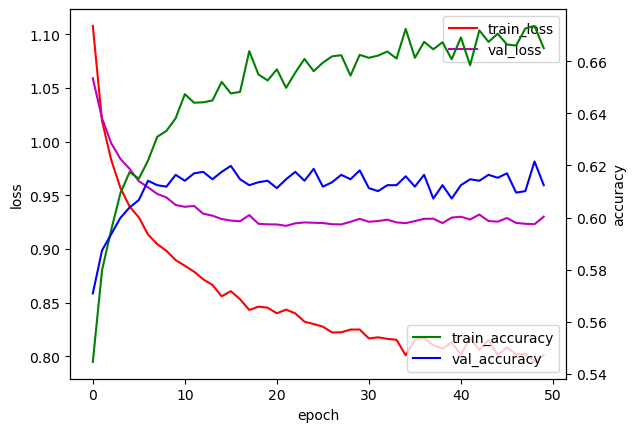

In [19]:
plot_training_progress(results_path)

## 6.3 Add weights to loss function

In [20]:
total_samples = 420 + 1190 + 2475 + 4696

proportion_conditional_edible = 420 / total_samples
proportion_deadly = 1190 / total_samples
proportion_edible = 2475 / total_samples
proportion_poisonous = 4696 / total_samples

weight_conditional_edible = 1 / proportion_conditional_edible
weight_deadly = 1 / proportion_deadly
weight_edible = 1 / proportion_edible
weight_poisonous = 1 / proportion_poisonous

In [21]:
ResNeXt_weightedloss = models.resnext101_64x4d(pretrained=True)

for param in ResNeXt_weightedloss.parameters():
    param.requires_grad = False

num_classes = 4
ResNeXt_weightedloss.fc = nn.Linear(ResNeXt_weightedloss.fc.in_features, num_classes)

# time recording start
start_time = time.time()

#TO COMPLETE --> Running you CNN model class
ResultPath = "./results/"
results_path = ResultPath + 'resnext-epochs50-adam-lr0.001-aug-bs128128-3080-top1-weightloss.pt'
nepochs = 50
ResNeXt_weightedloss.to(device)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(nepochs)
train_accuracy = np.zeros(nepochs)
val_loss = np.zeros(nepochs)
val_accuracy = np.zeros(nepochs)

class_weights = torch.tensor([weight_conditional_edible, weight_deadly, weight_edible, weight_poisonous]).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# Only last fc layer?
optimizer = torch.optim.Adam(ResNeXt_weightedloss.fc.parameters(), lr=0.001)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # train
    ResNeXt_weightedloss.train()
    for data in train_loader_aug:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = ResNeXt_weightedloss(inputs)

        # calculate top-k accuracy
        correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

        # accumulate accuracy for this batch
        num_correct_k = correct_k.item() / 100 * labels.size(0)
        correct += num_correct_k

        total += labels.size(0)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1    

    # record the mean loss for this epoch and show progress
    train_loss[epoch] = running_loss / n
    train_accuracy[epoch] = correct / total
    
    # reset variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # val
    ResNeXt_weightedloss.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward and accumulate loss
            outputs = ResNeXt_weightedloss(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            n += 1

            # calculate top-k accuracy
            correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

            num_correct_k = correct_k.item() / 100 * labels.size(0)
            correct += num_correct_k
            
            total += labels.size(0)

    # calculate test accuracy and loss
    val_loss[epoch] = running_loss / n
    val_accuracy[epoch] = correct / total

    print(f"epoch: {epoch+1} training loss: {train_loss[epoch]: .3f} training accuracy: {train_accuracy[epoch]: .1%}  val loss: {val_loss[epoch]: .3f} val accuracy: {val_accuracy[epoch]: .1%}")

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

# save network parameters and four features
data = {
    'state_dict': ResNeXt_weightedloss.state_dict(),
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
    'total_time': total_time
}
torch.save(data, results_path)

epoch: 1 training loss:  1.336 training accuracy:  38.5%  val loss:  1.275 val accuracy:  40.3%
epoch: 2 training loss:  1.232 training accuracy:  44.2%  val loss:  1.213 val accuracy:  37.2%
epoch: 3 training loss:  1.169 training accuracy:  44.0%  val loss:  1.176 val accuracy:  47.1%
epoch: 4 training loss:  1.135 training accuracy:  46.5%  val loss:  1.149 val accuracy:  44.6%
epoch: 5 training loss:  1.104 training accuracy:  46.5%  val loss:  1.130 val accuracy:  43.7%
epoch: 6 training loss:  1.082 training accuracy:  47.7%  val loss:  1.116 val accuracy:  42.5%
epoch: 7 training loss:  1.055 training accuracy:  49.3%  val loss:  1.105 val accuracy:  48.3%
epoch: 8 training loss:  1.035 training accuracy:  49.7%  val loss:  1.096 val accuracy:  44.7%
epoch: 9 training loss:  1.028 training accuracy:  49.7%  val loss:  1.089 val accuracy:  44.1%
epoch: 10 training loss:  1.017 training accuracy:  50.1%  val loss:  1.092 val accuracy:  47.9%
epoch: 11 training loss:  1.004 trainin

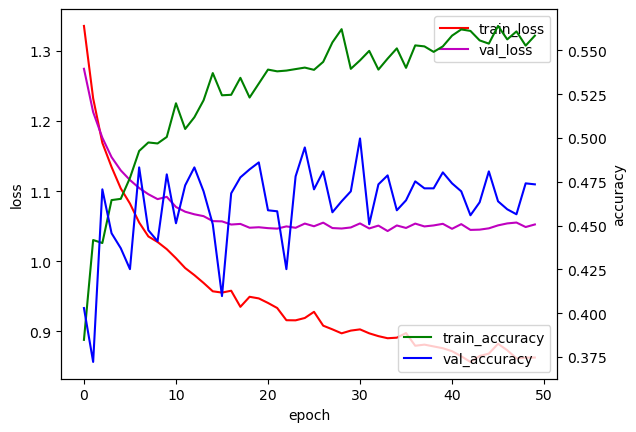

In [22]:
plot_training_progress(results_path)